In [14]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns 

# Ridge Regression

<u> Parameters to tune: </u>
- alpha non-negative float i.e. in [0, inf)
- solver

Read in data: 

In [2]:
embeddings = pd.read_pickle('/vol/data/ouologuems/systems_genetics/data/datasets/phase3_top10/embeddings_complete.pickle') 
sample_id = []
gene_id = []
embedding = []
for i in range(0, len(embeddings), 2):
    sid = embeddings[i][0].split(':')[1]
    gid = embeddings[i][0].split(':')[2]
    sample_id.append(sid)
    gene_id.append(gid)
    combined_embedding = embeddings[i][1] + embeddings[i+1][1]  # sum embedding
    embedding.append(combined_embedding)
df = pd.DataFrame({"sample_id": sample_id, "gene_id": gene_id, "embedding": embedding})
expression = pd.read_csv("/vol/data/ouologuems/systems_genetics/data/datasets/GD660.GeneQuantRPKM.txt", sep="\t")
expression = expression[expression["Gene_Symbol"].isin(df["gene_id"].values)]
expression = pd.melt(expression, id_vars=["TargetID", "Gene_Symbol", "Chr", "Coord"], var_name="sample_id", value_name="expression")
expression["sample_id"] = expression["sample_id"].str.split(".", expand=True)[0]
data = pd.merge(df, expression, left_on=["sample_id", "gene_id"], right_on=["sample_id", "Gene_Symbol"])

In [3]:
data.head()

,sample_id,gene_id,embedding,TargetID,Gene_Symbol,Chr,Coord,expression
0,NA20795,ENSG00000198502.5,"[0.020763932, -0.0043599964, 0.018072195, -0.0...",ENSG00000198502.5,ENSG00000198502.5,6,32498064,177.86778
1,HG00260,ENSG00000214425.1,"[0.034569502, 0.024124226, -0.06553179, -0.017...",ENSG00000214425.1,ENSG00000214425.1,17,43595264,0.48644
2,HG00173,ENSG00000238083.3,"[0.08705197, 0.056551743, 0.033424325, -0.0829...",ENSG00000238083.3,ENSG00000238083.3,17,44588877,6.83944
3,HG00178,ENSG00000229450.2,"[0.14517619, -0.016366798, -0.0096497275, -0.0...",ENSG00000229450.2,ENSG00000229450.2,4,120299287,0.08522
4,HG00158,ENSG00000179344.11,"[0.05826454, 0.0701687, 0.11973057, -0.0561387...",ENSG00000179344.11,ENSG00000179344.11,6,32636160,318.19590


In [4]:
data.gene_id.unique()

array(['ENSG00000198502.5', 'ENSG00000214425.1', 'ENSG00000238083.3',
       'ENSG00000229450.2', 'ENSG00000179344.11', 'ENSG00000237541.3',
       'ENSG00000196126.6', 'ENSG00000196735.6', 'ENSG00000176681.9',
       'ENSG00000232629.4'], dtype=object)

In [15]:
snp_data = pd.read_csv("/vol/data/ouologuems/systems_genetics/data/datasets/EUR373.gene.cis.FDR5.all.rs137.txt.gz", sep="\t")
snp_data.head()

,SNP_ID,ID,GENE_ID,PROBE_ID,CHR_SNP,CHR_GENE,SNPpos,TSSpos,distance,rvalue,pvalue,log10pvalue
0,rs1566523,-,ENSG00000142794.11,ENSG00000142794.11,1,1,21766663.0,21766621,42.0,-0.782786,3.883913e-78,77.410730
1,rs66732917,-,ENSG00000142794.11,ENSG00000142794.11,1,1,21766608.0,21766621,13.0,-0.775971,5.736684e-76,75.241339
2,rs12734589,-,ENSG00000142794.11,ENSG00000142794.11,1,1,21760127.0,21766621,6494.0,-0.753190,3.094123e-69,68.509462
3,rs4654745,-,ENSG00000142794.11,ENSG00000142794.11,1,1,21767096.0,21766621,475.0,-0.753071,3.339200e-69,68.476358
4,rs10916990,-,ENSG00000142794.11,ENSG00000142794.11,1,1,21763132.0,21766621,3489.0,-0.750913,1.327049e-68,67.877113


## Gene: ENSG00000198502.5

In [5]:
gene1 = data[data.gene_id == "ENSG00000198502.5"]

In [6]:
X = np.array(gene1["embedding"].values.tolist())
y = np.array(gene1.expression)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
ridge = Ridge()
params = {"alpha": uniform(1e-10, 10), "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]}

In [8]:
clf = RandomizedSearchCV(ridge, param_distributions = params, n_iter=20, scoring ="neg_mean_squared_error",
                         cv = 5,random_state=42, return_train_score=True)
search = clf.fit(X_train, y_train)

In [9]:
search.best_params_

{'alpha': 0.20584494305802448, 'solver': 'svd'}

In [10]:
search.best_score_

-10999.083720669605

In [11]:
ridge = search.best_estimator_
r2 = ridge.score(X_train, y_train)
r2

0.21672477522155964

In [12]:
y_pred = ridge.predict(X_train)
mean_squared_error(y_train, y_pred)

9927.64464887973

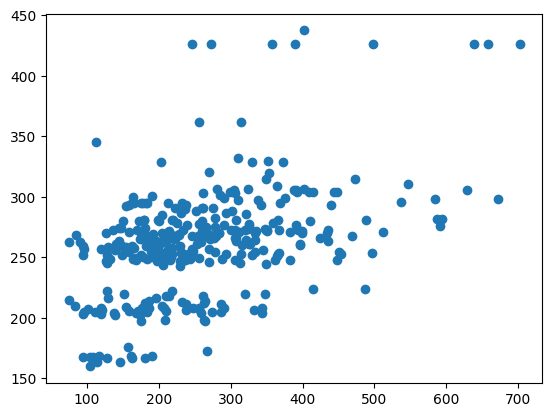

In [13]:
plt.scatter(y_train, y_pred)
plt.show()

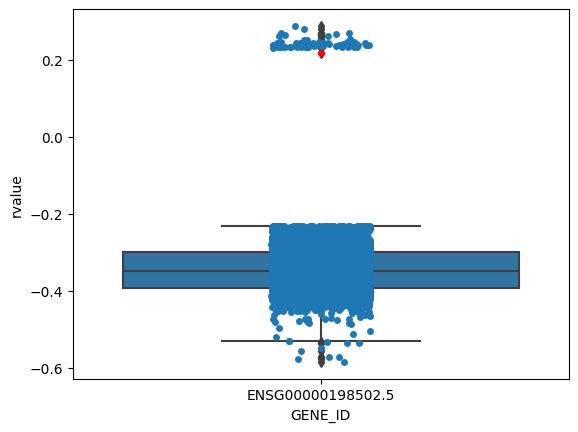

In [16]:
snp_gene1 = snp_data[snp_data.GENE_ID == "ENSG00000198502.5"]
snp_gene1.loc[len(snp_gene1.index)] = [None, None, "ENSG00000198502.5", None, None, None, None, None, None, r2, None, None]

# creating boxplot 
sns.boxplot(x = "GENE_ID", y ="rvalue", data=snp_gene1) 
# adding data points 
sns.stripplot(x = "GENE_ID", y ="rvalue",data=snp_gene1[snp_gene1.ID.notnull()]) 
sns.stripplot(x = "GENE_ID", y ="rvalue",data=snp_gene1[~snp_gene1.ID.notnull()], color="red") 
# display plot 
plt.show() 

In [141]:
#y_pred = ridge.predict(X_test)
#mean_squared_error(y_test, y_pred)

10351.31405183967

## Gene: ENSG00000196735.6

In [17]:
gene2 = data[data.gene_id == "ENSG00000196735.6"]

In [18]:
X = np.array(gene2["embedding"].values.tolist())
y = np.array(gene2.expression)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
ridge = Ridge()
params = {"alpha": uniform(1e-10, 10), "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]}
clf = RandomizedSearchCV(ridge, param_distributions = params, n_iter=20, scoring ="neg_mean_squared_error",
                         cv = 5,random_state=42, return_train_score=True)
search = clf.fit(X_train, y_train)

In [19]:
search.best_params_, search.best_score_

({'alpha': 0.20584494305802448, 'solver': 'svd'}, -20588.779243524834)

In [24]:
ridge = search.best_estimator_
r2 = ridge.score(X_train, y_train)
r2

0.4344103018204226

In [25]:
y_pred = ridge.predict(X_train)
mean_squared_error(y_train, y_pred)

18418.19045921099

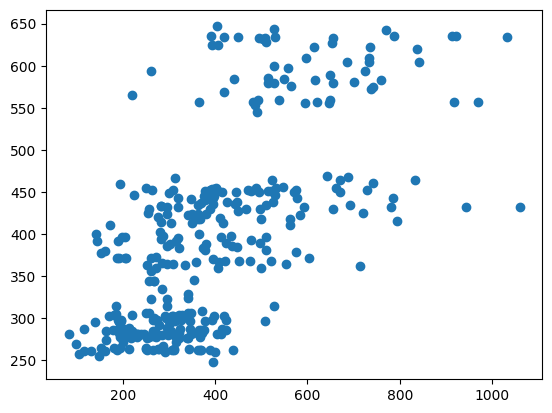

In [26]:
plt.scatter(y_train, y_pred)
plt.show()

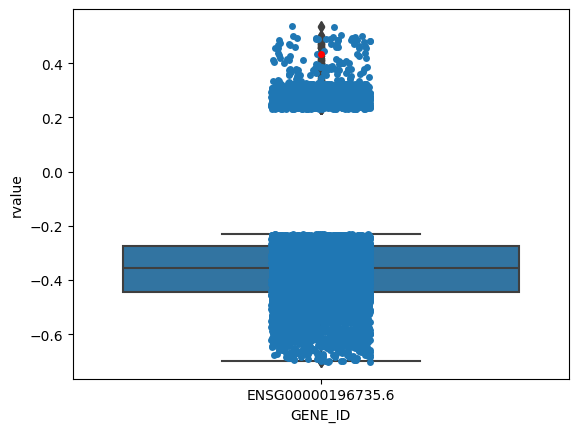

In [27]:
snp_gene2 = snp_data[snp_data.GENE_ID == "ENSG00000196735.6"]
snp_gene2.loc[len(snp_gene2.index)] = [None, None, "ENSG00000196735.6", None, None, None, None, None, None, r2, None, None]
# creating boxplot 
sns.boxplot(x = "GENE_ID", y ="rvalue", data=snp_gene2) 
  
# adding data points 
sns.stripplot(x = "GENE_ID", y ="rvalue",data=snp_gene2[snp_gene2.ID.notnull()]) 
sns.stripplot(x = "GENE_ID", y ="rvalue",data=snp_gene2[~snp_gene2.ID.notnull()], color="red") 
# display plot 
plt.show() 